# Análisis TI-CNN dataset (Parte 2)
En este notebook se realiza un análisis de la longitud de las dos categorías de noticias. Los resultados de este análisis son los que han permitido detectar el sesgo producido por la longitud de las noticias

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, '../')
import nlp_functions as nlp_f

In [2]:
# Cargamos el dataset preprocesado
df = pd.read_csv('../dataset/ticnn_preprocessed.csv')

In [3]:
df.head()

,text,type
0,"['donald', 'trump', 'property', 'showcase', 'b...",0.0
1,"['trump', 'foundation', 'tell', 'new', 'york',...",0.0
2,"['donald', 'trump', 'prepares', 'white', 'hous...",0.0
3,"['lure', 'chinese', 'investor', 'trump', 'name...",0.0
4,"['melania', 'barron', 'trump', 'wont', 'immedi...",0.0


El campo text está almacenado como string, lo convertimos a lista utilizando literal_eval

In [4]:
%%time
from ast import literal_eval
df['text'] = df['text'].apply(literal_eval)

Wall time: 15.7 s


In [5]:
df['length'] = df['text'].str.len()

In [6]:
df = df.sort_values(by=['length'])

In [7]:
pd.set_option('display.max_rows', 10000)

In [8]:
df.head()

,text,type,length
5652,[],1.0,0
6289,[nicely],1.0,1
4955,[brilliant],1.0,1
4974,[brilliant],1.0,1
4975,[brilliant],1.0,1


In [9]:
df_real = df.loc[df['type'] == 0.0]
df_fake = df.loc[df['type'] == 1.0]

In [10]:
len(df_fake)

11349

In [11]:
df_fake.tail()

,text,type,length
13027,"[reason, california, bad, state, america, reas...",1.0,9222
13046,"[barack, obama, wrong, fact, prove, illegal, i...",1.0,9589
13045,"[many, people, choose, leave, united, state, p...",1.0,10448
13056,"[many, people, migrate, california, water, dis...",1.0,10714
13047,"[hard, working, american, v, government, paras...",1.0,12212


In [12]:
df_real.tail()

,text,type,length
1533,"[trump, transition, wsj, paul, gigot, welcome,...",0.0,3965
16385,"[daily, many, african, american, unenthusiasti...",0.0,4078
1765,"[close, argument, wsj, paul, gigot, welcome, j...",0.0,4095
17011,"[inside, war, coal, war, coal, political, rhet...",0.0,4098
4272,"[guide, new, york, election, new, york, voting...",0.0,4439


# Frecuencia absoluta
En estas gráficas ya puede observarse que las noticias falsas tienden a ser más cortas

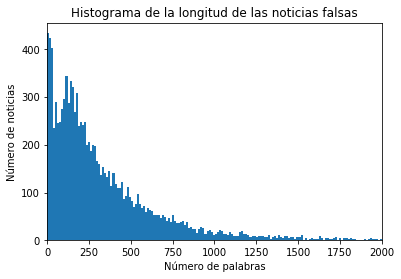

In [13]:
plt.title('Histograma de la longitud de las noticias falsas')
plt.hist(df_fake['length'], bins = 1000) #, bins = 1000
plt.xlabel('Número de palabras')
plt.ylabel('Número de noticias')
# plt.ylim([0, 600])
plt.xlim([0, 2000])
plt.show()

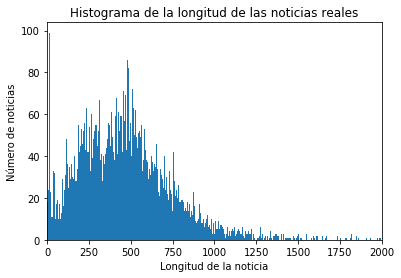

In [14]:
plt.title('Histograma de la longitud de las noticias reales')
plt.hist(df_real['length'], bins = 1000) #, bins = 1000
plt.xlabel('Longitud de la noticia')
plt.ylabel('Número de noticias')
# plt.ylim([0, 400])
plt.xlim([0, 2000])
plt.show()

# Media y desviación típica
La fórmula de la desviación típica es la siguiente:
$$ \sigma = \sqrt{ \frac{ \sum{ (x - \bar{x})^2 }}{n - 1} } $$
Definimos la función compute_avg_stdev, que calcula la media, la desviación típica y el valor máximo de una lista de integers

In [15]:
import math

def compute_avg_stdev(length_list):

    max_len = 0.
    average_len = 0.

    for new in length_list:
        average_len = average_len + new
        if new > max_len:
            max_len = new
        
    average_len = average_len / len(length_list)


    # Calculamos también la desviación estándar, para calcular como de desviados están los
    # datos con respecto a la media
    nominator = 0.
    for new in length_list:
        # El numerador se eleva al cuadrado (x - x_avg)^2
        nominator = nominator + ((new - average_len)**2)
  
    stdev = math.sqrt(nominator / (len(length_list) - 1))
    
    return average_len, stdev, max_len

In [16]:
compute_avg_stdev(df_fake['length'])

(372.23420565688605, 523.7515708047649, 12212)

In [17]:
compute_avg_stdev(df_real['length'])

(485.0068119891008, 352.41782324203245, 4439)

In [18]:
compute_avg_stdev(df['length'])

(419.1129588632034, 463.6729172626709, 12212)

_| Media Aritmética | Desviación típica | Noticia más larga
--- |--- | --- | ---
Real |485.11 | 352.42 | 4439
Fake |372.23| 523.75 | 12212
Total| 419.11 | 463.67 | 12212

Podemos observar que, en base a la media aritmética, la diferencia de longitud entre las noticias no es demasiado pronunciada. Aunque la desviación típica indica que la media en el caso de las noticias falsas tiene una mayor dispersión.

# Mediana y  percentiles (Cuantiles)
mediana es aquel valor que divide las observaciones en dos partes iguales, es decir, deja a su izquierda el 50 % de las observaciones y a su derecha el otro 50 %. Matemáticamente, corresponde al punto xi tal que Fi = 1/2 (o equivalente, Ni = n/2). <br>

En el paper original, simplemente se emplea la media aritmética. De acuerdo con dicho paper, hay una media de 4360 palabras en las noticias reales, con una media de 3943 palabras en las noticias falsas, con una proporción entre ambas de 1.1057. Este dato puede hacernos pensar que la diferencia de longitud entre ambos tipos de noticias no es demasiado grande. No obstante, si tenemos en cuenta los percentiles (cuantiles y mediana) nos damos cuenta de que las proporciones entre ambos tipos de noticia son mucho más pronunciadas.  <br>

Que la media tenga valores similares se debe a la dispersión de las fake news, mostrada en la gráfica anterior, ya que hay algunas noticias falsas que tienen una longitud muy superior a la que podría ser más representativa, por lo que podemos concluir que la media no es un valor muy representativo a causa de lo dispersos que están los datos.

Si empleamos los percentiles nos damos cuenta de que la diferencia de longitud entre ambos tipos de noticias es mucho más pronunciada de lo que podría parecer en un principio, siendo la longitud de las noticias reales el doble de la de las noticias falsas en muchos casos, exceptuando las noticias fake más largas. <br>

Esto puede deberse a la forma en la que se han extraído los datos, al tratarse de dos datasets distintos mergeados. <br>

La proporción utilizando la mediana es de 1.91, casi el doble. Este valor dista mucho del indicado por la media

In [19]:
percentiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.]
percentiles_2 = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.93, 0.95, 0.97, 1.]

In [20]:
per_real = df_real.quantile(percentiles).drop(columns='type')
per_real.rename(columns = {'length' : 'length real'}, inplace = True)

per_fake = df_fake.quantile(percentiles).drop(columns='type')
per_fake.rename(columns = {'length' : 'length fake'}, inplace = True)

per_both = pd.concat([per_real, per_fake], axis = 1)

per_both['proportion'] = per_both['length real'] / per_both['length fake']

per_both

,length real,length fake,proportion
0.1,142.0,31.0,4.580645
0.2,230.0,85.0,2.705882
0.3,302.0,132.0,2.287879
0.4,378.0,177.0,2.135593
0.5,445.0,232.0,1.918103
0.6,507.0,303.0,1.673267
0.7,579.0,401.0,1.443890
0.8,675.4,542.4,1.245206
0.9,828.0,797.0,1.038896
1.0,4439.0,12212.0,0.363495


In [21]:
list(per_both.index)

[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

In [22]:
df_fake['length'].mean(axis = 0) 
# df_real['length'].mean(axis = 0) 

372.23420565688605

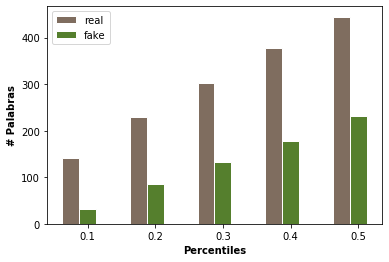

In [23]:
# libraries
import numpy as np
import matplotlib.pyplot as plt
 
# Anchura
barWidth = 0.25
 
# Altura
bars1 = list(per_both['length real'])[0:5]
bars2 = list(per_both['length fake'])[0:5]
 
# Posición en el eje x
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Imprimir
plt.bar(r1, bars1, color='#7f6d5f', width=barWidth, edgecolor='white', label='real')
plt.bar(r2, bars2, color='#557f2d', width=barWidth, edgecolor='white', label='fake')

plt.ylabel('# Palabras', fontweight='bold')
plt.xlabel('Percentiles', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], list(per_both.index)[0:5])
 
# Leyenda e imprimir
plt.legend()
plt.show()


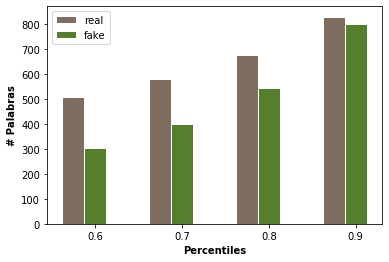

In [24]:
# Anchura
barWidth = 0.25
 
# Altura
bars1 = list(per_both['length real'])[5:9]
bars2 = list(per_both['length fake'])[5:9]
 
# Posición en el eje x
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Imprimir
plt.bar(r1, bars1, color='#7f6d5f', width=barWidth, edgecolor='white', label='real')
plt.bar(r2, bars2, color='#557f2d', width=barWidth, edgecolor='white', label='fake')

plt.ylabel('# Palabras', fontweight='bold')
plt.xlabel('Percentiles', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], list(per_both.index)[5:9])
 
# Leyenda e imprimir
plt.legend()
plt.show()

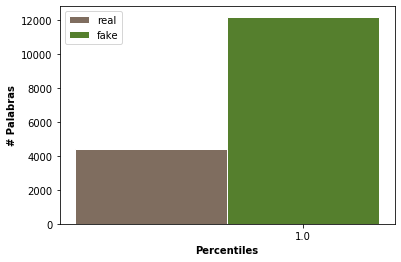

In [25]:
# Anchura
barWidth = 0.25
 
# Altura
bars1 = list(per_both['length real'])[9:]
bars2 = list(per_both['length fake'])[9:]
 
# Posición en el eje x
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Imprimir
plt.bar(r1, bars1, color='#7f6d5f', width=barWidth, edgecolor='white', label='real')
plt.bar(r2, bars2, color='#557f2d', width=barWidth, edgecolor='white', label='fake')

plt.ylabel('# Palabras', fontweight='bold')
plt.xlabel('Percentiles', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], list(per_both.index)[9:])
 
# Leyenda e imprimir
plt.legend()
plt.show()